In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from matplotlib import cm
import tensorflow_probability as tfp

In [2]:
collocationNum = 10000
SeedNum = 1000
batchSize = 1000

boundaryNum = 500

tMin = 0.
tMax = 1.

xMin = -1.
xMax = 1.

lowerBound = tf.constant([tMin, xMin], dtype = 'float32')
upperBound = tf.constant([tMax, xMax], dtype = 'float32')

tColPoint = tf.random.uniform((collocationNum, 1), tMin, tMax)
xColPoint = tf.random.uniform((collocationNum, 1), xMin, xMax)
colPoint = tf.concat((tColPoint, xColPoint), axis = 1)

tSeedPoint = tf.random.uniform((SeedNum, 1), tMin, tMax)
xSeedPoint = tf.random.uniform((SeedNum, 1), xMin, xMax)
seedPoint = tf.concat((tSeedPoint, xSeedPoint), axis = 1)

tInitialPoint = tf.zeros((boundaryNum, 1))
xInitialPoint = tf.random.uniform((boundaryNum, 1), xMin, xMax)
initialPoint = tf.concat((tInitialPoint, xInitialPoint), axis = 1)

tBoundaryPoint = tf.random.uniform((boundaryNum, 1), tMin, tMax)
xBoundaryPoint1 = tf.ones((boundaryNum // 2, 1))
xBoundaryPoint2 = -tf.ones((boundaryNum // 2, 1))
xBoundaryPoint = tf.concat((xBoundaryPoint1, xBoundaryPoint2), axis = 0)
boundaryPoint = tf.concat((tInitialPoint, xInitialPoint), axis = 1)

In [3]:
# pip install smt;
from smt.sampling_methods import LHS
def LHS_sampling(lb,ub,collocationNum):
    xlimits = np.array([[lb[0], ub[0]], [lb[1], ub[1]]])
    sampling = LHS(xlimits=xlimits)
    x = sampling(collocationNum)
    return tf.cast(tf.convert_to_tensor(x), tf.float32)

In [4]:
# nearest neighbor
npSeed = seedPoint.numpy()
npPoints = colPoint.numpy()
distance = (-2 * npSeed @ npPoints.T 
    + np.sum(npSeed ** 2, axis = 1)[:, np.newaxis] 
    + np.sum(npPoints ** 2, axis = 1).T)
nearestSeedIndex =  np.argsort(distance, axis = 0)[0:1, :].T
nearestSeedIndex = tf.convert_to_tensor(nearestSeedIndex)
print(nearestSeedIndex.shape) # should be (NPoint, 1) np array

(10000, 1)


In [5]:
def initiateModel(numHiddenLayers = 8, numNeuronsPerLayer = 20):
    '''return newly initilized model'''
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))
    model.add(tf.keras.layers.Lambda(
        lambda x: 2.0 * (x - lowerBound) / (upperBound - lowerBound) - 1.0))
    for _ in range(numHiddenLayers):
        model.add(tf.keras.layers.Dense(
            numNeuronsPerLayer, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))
    return model
@tf.function
def getResidual(model, input):
    # input is tensor
    with tf.GradientTape(persistent=True) as tape:
        t = input[:, 0:1]
        x = input[:, 1:2]
        tape.watch(t)
        tape.watch(x)
        u = model(tf.concat((t, x), axis = 1))
        dudx = tape.gradient(u, x)
    dudt = tape.gradient(u, t)
    dudx2 = tape.gradient(dudx, x)
    del tape
    return dudt + u * dudx - (0.01 / np.pi) * dudx2

def getBoundaryLoss(model, initialPoint, boundaryPoint):
    boundaryU = model(boundaryPoint)
    loss = tf.reduce_sum(tf.square(boundaryU))
    initialU = model(initialPoint)
    loss += tf.reduce_sum(tf.square(initialU + tf.sin(np.pi * initialPoint[:, 0:1])))
    return loss

def getLoss(model, input):
    residual = getResidual(model, input) #(N, 1)
    totalLoss = tf.reduce_sum(tf.square(residual))
    return totalLoss

def getGradient(model, input, initialPoint, boundaryPoint):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        loss = getLoss(model, input)
        loss += getBoundaryLoss(model, initialPoint, boundaryPoint)
        gradient = tape.gradient(loss, model.trainable_variables)
    return loss, gradient

def uniformSampling(input):
    originalSet = tf.data.Dataset.from_tensor_slices(input)
    newSet = tf.data.Dataset.sample_from_datasets([originalSet]).batch(batchSize)
    for i in newSet:
        return i

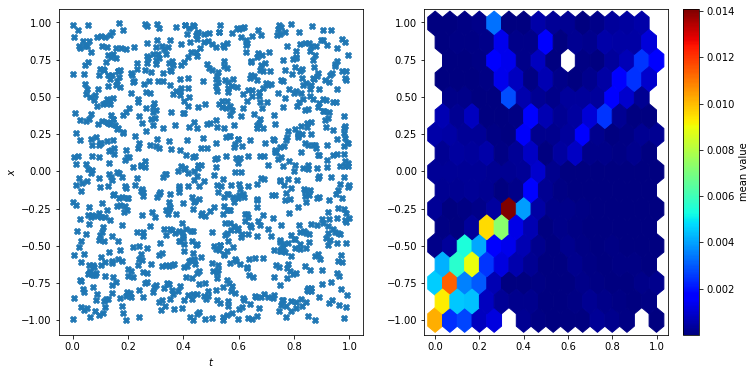

In [89]:
# functions for importance sampling

def importanceSampling(model, seedPoint):
    loss = tf.square(getResidual(model, seedPoint))
    probability = tf.gather(indices = nearestSeedIndex, params = loss[:, 0])
    total = tf.reduce_sum(probability)
    sampleIndex = tf.random.categorical(tf.math.log(tf.transpose(probability)), batchSize)
    sample = tf.gather(indices=sampleIndex, params=colPoint)[0, :, :]
    sampleProbability = tf.gather(indices=sampleIndex, params=probability)[0, :, :] / total
    return sample, sampleProbability

def getLossWithImportanceSampling(model, input, inputProbability):
    residual = getResidual(model, input)
    totalLoss = tf.reduce_sum(tf.square(residual) / inputProbability / collocationNum)
    return totalLoss

def getGradientWithImportantSampling(model, input, inputProbability, initialPoint, boundaryPoint):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        loss = getLossWithImportanceSampling(model, input, inputProbability)
        loss += getBoundaryLoss(model, initialPoint, boundaryPoint)
        gradient = tape.gradient(loss, model.trainable_variables)
    return loss, gradient

model = initiateModel()
def visualizeSamplingFunction(samplingFun):
    sample, sampleProbability = samplingFun(model, seedPoint)
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.scatter(sample[:,0], sample[:, 1], marker='X', vmin=-1, vmax=1)
    # plt.scatter(tSeedPoint, xSeedPoint, marker='X', vmin=-1, vmax=1)
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.subplot(1,2,2)
    plt.hexbin(seedPoint[:, 0], seedPoint[:, 1], C=tf.square(getResidual(model, seedPoint)), cmap=cm.jet, gridsize=15, bins=None)
    cb = plt.colorbar()
    cb.set_label('mean value')

visualizeSamplingFunction(importanceSampling)

tf.Tensor(
[[0.31061137 0.7642572 ]
 [0.31061137 0.7642572 ]
 [0.31061137 0.7642572 ]
 ...
 [0.31402254 0.79999787]
 [0.31402254 0.79999787]
 [0.31402254 0.79999787]], shape=(1000, 2), dtype=float32)


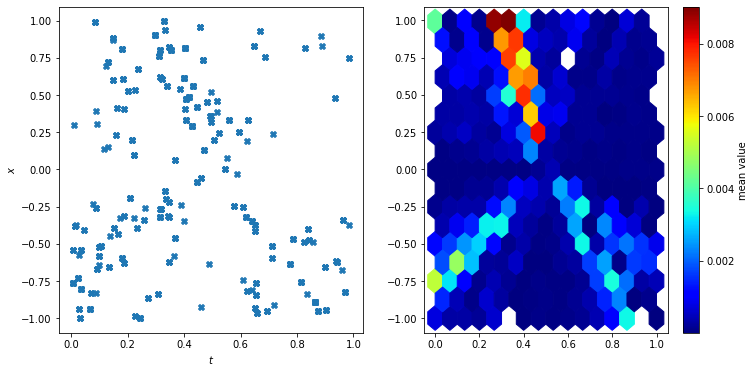

In [85]:
# functions for MCMC method
@tf.function
def randomWalkMetropolis(model): # no seeding, super slow
  def probByLoss(point):
    if tf.reduce_min(point - lowerBound) < 0 or tf.reduce_min(upperBound - point) < 0: 
      return tf.constant(-1e10)
    else:
      return tf.math.log(getLoss(model, point[tf.newaxis, :]))
  def genNewState(point):
    if tf.reduce_min(point - lowerBound) < 0 or tf.reduce_min(upperBound - point) < 0: 
      return tf.constant(-1e10)
    else:
      return tf.math.log(getLoss(model, point[tf.newaxis, :]))
  kernel = tfp.mcmc.RandomWalkMetropolis(probByLoss)
  state = colPoint[0, :]
  extra = kernel.bootstrap_results(state)
  return tfp.mcmc.sample_chain(
    batchSize,
    state,
    previous_kernel_results=None,
    kernel=kernel,
    num_burnin_steps=5,
    num_steps_between_results=2,
    return_final_kernel_results=False,
    trace_fn = None,
    parallel_iterations=20,
  )

def randomWalkMetropolisWithSeeding(model):
  loss = tf.square(getResidual(model, seedPoint))
  probability = tf.gather(indices = nearestSeedIndex, params = loss[:, 0])[:,0]
  logProbability = tf.math.log(probability)
  def probByLoss(index):
    return tf.gather(indices=tf.cast(index, dtype='int32') % collocationNum, params=logProbability)
  def newState(index, seed):
    return tf.cast(tf.cast(tf.random.normal([1], index, collocationNum / 3), dtype = 'int32') % collocationNum, dtype='float32')
  kernel = tfp.mcmc.RandomWalkMetropolis(probByLoss, new_state_fn=newState)
  state = tf.constant(0.)
  extra = kernel.bootstrap_results(state)
  sampleIndex = tfp.mcmc.sample_chain(
    batchSize,
    state,
    previous_kernel_results=extra,
    kernel=kernel,
    num_burnin_steps=5,
    num_steps_between_results=1,
    return_final_kernel_results=False,
    trace_fn = None,
    parallel_iterations=10,
  )
  sampleIndex = tf.cast(sampleIndex, dtype='int32')
  sample = tf.gather(indices=sampleIndex, params=colPoint)
  total = tf.reduce_sum(probability)
  sampleProbability = tf.gather(indices=sampleIndex, params=probability) / total
  return sample, sampleProbability
# tf.gather(indices=sampleIndex, params=colPoint)[0, :, :]

def randomWalkMetropolisWithSeedingAndParallel(model, n):
  loss = tf.square(getResidual(model, seedPoint))
  probability = tf.gather(indices = nearestSeedIndex, params = loss[:, 0])[:,0]
  logProbability = tf.math.log(probability)
  def probByLoss(index):
    return tf.reduce_sum(tf.gather(indices=tf.cast(index, dtype='int32') % collocationNum, params=logProbability))
  def newState(index, seed):
    return tf.cast(tf.cast(index + tf.random.normal([n], 0, collocationNum / 3), dtype = 'int32') % collocationNum, dtype='float32')
  kernel = tfp.mcmc.RandomWalkMetropolis(probByLoss, new_state_fn=newState)
  state = tf.zeros((n))
  extra = kernel.bootstrap_results(state)
  sampleIndex = tfp.mcmc.sample_chain(
    batchSize // n,
    state,
    previous_kernel_results=extra,
    kernel=kernel,
    num_burnin_steps=5,
    num_steps_between_results=2,
    return_final_kernel_results=False,
    trace_fn = None,
    parallel_iterations=10,
  )
  sampleIndex = tf.cast(sampleIndex, dtype='int32')
  sampleIndex = tf.reshape(sampleIndex, (batchSize // n * n))
  sample = tf.gather(indices=sampleIndex, params=colPoint)
  total = tf.reduce_sum(probability)
  sampleProbability = tf.gather(indices=sampleIndex, params=probability) / total
  return sample, sampleProbability

# model = initiateModel()
#sample, sampleProbability = randomWalkMetropolisWithSeeding(model)
#sample, sampleProbability = randomWalkMetropolisWithSeedingAndParallel(model, 5)
sample = randomWalkMetropolis(model)
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.scatter(sample[:,0], sample[:, 1], marker='X', vmin=-1, vmax=1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.subplot(1,2,2)
plt.hexbin(seedPoint[:, 0], seedPoint[:, 1], C=tf.square(getResidual(model, seedPoint)), cmap=cm.jet, gridsize=15, bins=None)
cb = plt.colorbar()
cb.set_label('mean value')
print(sample)

tf.Tensor(
[[ 0.66115373  0.83227676]
 [ 0.32458124  0.898143  ]
 [ 0.3377199   0.82198954]
 ...
 [ 0.76546824 -0.6701117 ]
 [ 0.7020044  -0.50415987]
 [ 0.7020044  -0.50415987]], shape=(1000, 2), dtype=float32)


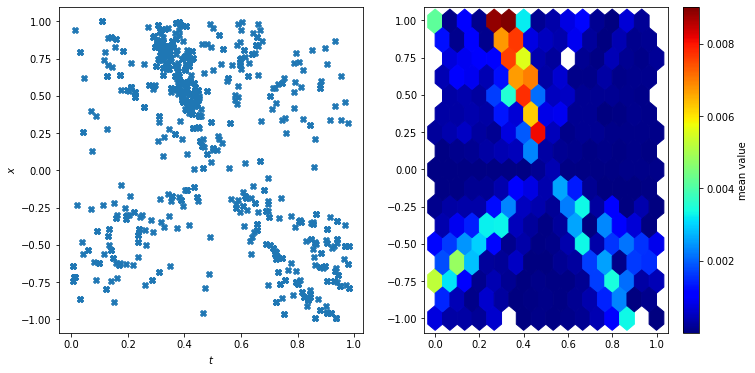

In [86]:
@tf.function
def HamiltonianMC(model): # no seeding, super slow
  def probByLoss(point):
    if tf.reduce_min(point - lowerBound) < 0 or tf.reduce_min(upperBound - point) < 0: 
      return tf.constant(-1e10)
    else:
      return tf.math.log(getLoss(model, point[tf.newaxis, :]))
  def genNewState(point):
    if tf.reduce_min(point - lowerBound) < 0 or tf.reduce_min(upperBound - point) < 0: 
      return tf.constant(-1e10)
    else:
      return tf.math.log(getLoss(model, point[tf.newaxis, :]))
  # kernel = tfp.mcmc.RandomWalkMetropolis(probByLoss)
  kernel = tfp.mcmc.MetropolisHastings(
    tfp.mcmc.UncalibratedHamiltonianMonteCarlo(
        target_log_prob_fn= probByLoss,
        step_size=0.1,
        num_leapfrog_steps=3))
  state = colPoint[0, :]
  # extra = kernel.bootstrap_results(state)
  return tfp.mcmc.sample_chain(
    batchSize,
    state,
    previous_kernel_results=None,
    kernel = kernel,
    num_burnin_steps=5,
    num_steps_between_results=2,
    return_final_kernel_results=False,
    trace_fn = None,
    parallel_iterations=20,
  )

# model = initiateModel()
sample = HamiltonianMC(model)
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.scatter(sample[:,0], sample[:, 1], marker='X', vmin=-1, vmax=1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.subplot(1,2,2)
plt.hexbin(seedPoint[:, 0], seedPoint[:, 1], C=tf.square(getResidual(model, seedPoint)), cmap=cm.jet, gridsize=15, bins=None)
cb = plt.colorbar()
cb.set_label('mean value')
print(sample)

tf.Tensor(
[[0.2971587  0.81945986]
 [0.46669507 0.27746126]
 [0.44020346 0.48297822]
 ...
 [0.29415366 0.97137606]
 [0.31086457 0.8256772 ]
 [0.34044045 0.6940268 ]], shape=(1000, 2), dtype=float32)


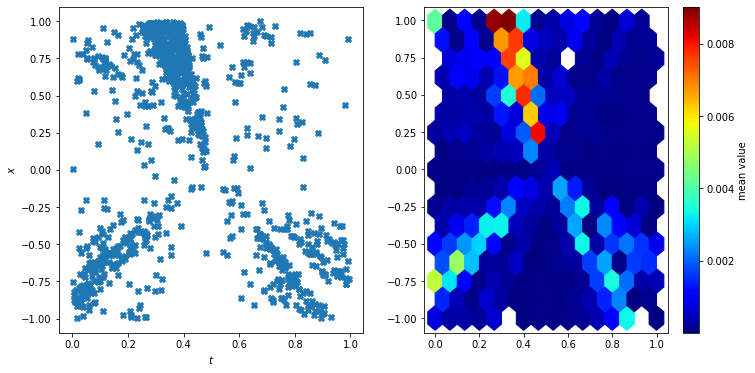

In [87]:
@tf.function
def Slice(model): # no seeding, super slow
  def probByLoss(point):
    if tf.reduce_min(point - lowerBound) < 0 or tf.reduce_min(upperBound - point) < 0: 
      return tf.constant(-1e10)
    else:
      return tf.math.log(getLoss(model, point[tf.newaxis, :]))
  def genNewState(point):
    if tf.reduce_min(point - lowerBound) < 0 or tf.reduce_min(upperBound - point) < 0: 
      return tf.constant(-1e10)
    else:
      return tf.math.log(getLoss(model, point[tf.newaxis, :]))
  # kernel = tfp.mcmc.RandomWalkMetropolis(probByLoss)
  kernel = tfp.mcmc.SliceSampler(
        probByLoss,
        step_size=1.0,
        max_doublings=5)
  state = colPoint[0, :]
  # extra = kernel.bootstrap_results(state)
  return tfp.mcmc.sample_chain(
    batchSize,
    state,
    previous_kernel_results=None,
    kernel = kernel,
    num_burnin_steps=5,
    num_steps_between_results=2,
    return_final_kernel_results=False,
    trace_fn = None,
    parallel_iterations=20,
  )

# model = initiateModel()
sample = Slice(model)
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.scatter(sample[:,0], sample[:, 1], marker='X', vmin=-1, vmax=1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.subplot(1,2,2)
plt.hexbin(seedPoint[:, 0], seedPoint[:, 1], C=tf.square(getResidual(model, seedPoint)), cmap=cm.jet, gridsize=15, bins=None)
cb = plt.colorbar()
cb.set_label('mean value')
print(sample)

In [10]:
#@tf.function
def trainStep(model, input, initialPoint, boundaryPoint):
    loss, gradient = getGradient(model, input, initialPoint, boundaryPoint)
    optim.apply_gradients(zip(gradient, model.trainable_variables))
    return loss

def trainModel(model, input, trainingEpisode, initialPoint, boundaryPoint):
    t0 = time()
    hist = []
    histTime = []
    for i in range(trainingEpisode):
        if i % 100 == 0 :
            print("doing {0} training".format(i))
        loss = trainStep(model, uniformSampling(input), initialPoint, boundaryPoint)
        hist.append(loss.numpy())
        histTime.append(time() - t0)
    return hist, histTime

In [11]:
#@tf.function
def trainStepWithImportanceSampling(model, input, inputProbability, initialPoint, boundaryPoint):
    loss, gradient = getGradientWithImportantSampling(model, input, inputProbability, initialPoint, boundaryPoint)
    optim.apply_gradients(zip(gradient, model.trainable_variables))
    return loss

def trainModelWithImportanceSampling(model, input, trainingEpisode, initialPoint, boundaryPoint):
    t0 = time()
    hist = []
    histTime = []
    for i in range(trainingEpisode):
        if i % 100 == 0 :
            print("doing {0}th training".format(i))
        sample, sampleProbability = importanceSampling(model, seedPoint)
        loss = trainStepWithImportanceSampling(model, sample, sampleProbability, initialPoint, boundaryPoint)
        hist.append(loss.numpy())
        histTime.append(time() - t0)
    return hist, histTime

In [12]:
#@tf.function
def trainStepWithMCMC(model, input, initialPoint, boundaryPoint):
    loss, gradient = getGradient(model, input, initialPoint, boundaryPoint)
    optim.apply_gradients(zip(gradient, model.trainable_variables))
    return loss

def trainModelMCMC(model, method, input, trainingEpisode, initialPoint, boundaryPoint):
    t0 = time()
    hist = []
    histTime = []
    for i in range(trainingEpisode):
        if i % 100 == 0 :
            print("doing {0} training".format(i))
        loss = trainStepWithMCMC(model, method(model), initialPoint, boundaryPoint)
        hist.append(loss.numpy())
        histTime.append(time() - t0)
    return hist, histTime

In [164]:
originModel = initiateModel()
optim = tf.keras.optimizers.Adam(learning_rate=0.002)

In [213]:
hist_np = np.zeros(100)
for i in range(10):
  originModel = initiateModel()
  optim = tf.keras.optimizers.Adam(learning_rate=0.002)
  model = tf.keras.models.clone_model(originModel)
  model.set_weights(originModel.get_weights()) 
  hist, histTime = trainModel(model, colPoint, 100, initialPoint, boundaryPoint)
  hist_np += np.asarray(hist)
hist_np = hist_np/10

doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training


In [186]:
# model = tf.keras.models.clone_model(originModel)
# model.set_weights(originModel.get_weights()) 
# hist2, histTime2 = trainModel(model, LHS_sampling(lowerBound, upperBound, collocationNum), 100, initialPoint, boundaryPoint)

hist_np2 = np.zeros(100)
for i in range(10):
  originModel = initiateModel()
  optim = tf.keras.optimizers.Adam(learning_rate=0.002) 
  model = tf.keras.models.clone_model(originModel)
  model.set_weights(originModel.get_weights()) 
  hist2, histTime2 = trainModel(model, LHS_sampling(lowerBound, upperBound, collocationNum), 100, initialPoint, boundaryPoint)
  hist_np2 += np.asarray(hist2)
hist_np2 = hist_np2/10

doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training


In [191]:
# model = tf.keras.models.clone_model(originModel)
# model.set_weights(originModel.get_weights()) 
# hist3, histTime3 = trainModelWithImportanceSampling(model, colPoint, 100, initialPoint, boundaryPoint)
hist_np3 = np.zeros(100)
for i in range(10):
  originModel = initiateModel()
  optim = tf.keras.optimizers.Adam(learning_rate=0.002)
  model = tf.keras.models.clone_model(originModel)
  model.set_weights(originModel.get_weights()) 
  hist3, histTime3 = trainModelWithImportanceSampling(model, colPoint, 100, initialPoint, boundaryPoint)
  hist_np3 += np.asarray(hist3)
hist_np3 = hist_np3/10

doing 0th training
doing 0th training
doing 0th training
doing 0th training
doing 0th training
doing 0th training
doing 0th training
doing 0th training
doing 0th training
doing 0th training


In [193]:
 # model = tf.keras.models.clone_model(originModel)
# model.set_weights(originModel.get_weights()) 
# hist4, histTime4 = trainModelMCMC(model, randomWalkMetropolis, colPoint, 100, initialPoint, boundaryPoint)
hist_np4 = np.zeros(100)
for i in range(10):
  model = tf.keras.models.clone_model(originModel)
  model.set_weights(originModel.get_weights()) 
  hist4, histTime4 = trainModelMCMC(model, randomWalkMetropolis, colPoint, 100, initialPoint, boundaryPoint)
  hist_np4 += np.asarray(hist4)
hist_np4 = hist_np4/10

doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training


In [139]:
# model = tf.keras.models.clone_model(originModel)
# model.set_weights(originModel.get_weights()) 
# hist5, histTime5 = trainModelMCMC(model, HamiltonianMC, colPoint, 100, initialPoint, boundaryPoint)
hist_np5 = np.zeros(100)
for i in range(10):
  model = tf.keras.models.clone_model(originModel)
  model.set_weights(originModel.get_weights()) 
  hist5, histTime2 = trainModelMCMC(model, HamiltonianMC, colPoint, 100, initialPoint, boundaryPoint)
  hist_np5 += np.asarray(hist5)
hist_np5 = hist_np5/10

doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training
doing 0 training


In [24]:
# hist6, histTime6 = trainModelMCMC(initiateModel(), Slice, colPoint, 100, initialPoint, boundaryPoint)

In [76]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

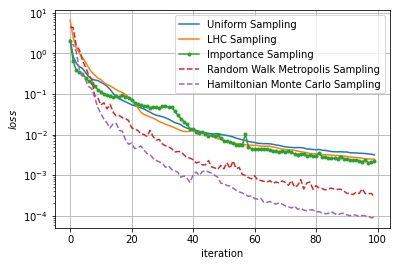

In [194]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
# ax.semilogy(range(len(hist)), hist_np, '-', label = "Uniform Sampling")
# ax.semilogy(range(len(hist)), hist2, '-', label = "LHC Sampling")
# ax.semilogy(range(len(hist)), hist3, '.-', label = "Importance Sampling")
# # ax.semilogy(range(len(hist)), hist3, '.-', label = "Importance Sampling + LHC")
# ax.semilogy(range(len(hist)), hist4, '--', label = "Random Walk Metropolis Sampling")
# ax.semilogy(range(len(hist)), hist5, '--', label = "Hamiltonian Monte Carlo Sampling")
# # ax.semilogy(range(len(hist)), hist6, '--', label = "Slice Sampling")
ax.semilogy(range(len(hist)), hist_np, '-', label = "Uniform Sampling")
ax.semilogy(range(len(hist)), hist_np2, '-', label = "LHC Sampling")
ax.semilogy(range(len(hist)), hist_np3, '.-', label = "Importance Sampling")
# ax.semilogy(range(len(hist)), hist3, '.-', label = "Importance Sampling + LHC")
ax.semilogy(range(len(hist)), hist_np4, '--', label = "Random Walk Metropolis Sampling")
ax.semilogy(range(len(hist)), hist_np5, '--', label = "Hamiltonian Monte Carlo Sampling")
# ax.semilogy(range(len(hist)), hist6, '--', label = "Slice Sampling")

ax.set_xlabel('iteration')
ax.set_ylabel('$loss$')
plt.grid()
plt.legend()
# from google.colab import files
# plt.savefig('PINN_benchmark.eps', format='eps')
# files.download("PINN_benchmark.eps") 

AttributeError: ignored

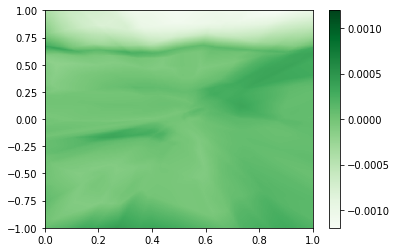

In [225]:
z_min, z_max = -np.abs(U).max(), np.abs(U).max()
     
c = plt.pcolormesh(T, X, U, cmap ='Greens', vmin = z_min, vmax = z_max)
plt.colorbar(c)
plt.set_xlabel('$t$')
plt.set_ylabel('$x$')

from google.colab import files
plt.savefig('PINN_solution.png', format='png')
files.download("PINN_solution.png") 